# Exercise 4: Reimplement the Euler Solvers

- In the second exercise, you implemented the simple and improved Euler solvers using functions. After today's lecture, you're ready to take a more structured approach. 


- Conceputally, we could think of the procedure for solving an ODE as involving three objects:

    1. An ODE problem type, which consists of the right-hand side function, initial conditions, parameters and timespan of your problem.
    2. An ODE algorithm type, which describes a specific solver algorithm.
    3. An ODE solution type, which contains the computed trajectory and the times where the solver stopped.


- For this week's exercise:
    1. Create structs for each of these object types. 
    2. Write a function `solve` that accepts instances of your problem and algorithm types, like `solve(prob, alg)`, and carries out the correct procedure for the given solver algorithm. Your `solve` function should return an instance of your solution type.
    3. Bonus: Write a method for the `plot` function from the `Plots` package which accepts an instance of your solution object and makes a sensible plot, like `plot(solution)`.
    4. Test your solvers on the Lotka-Volterra system.


- Hints:
    - Structs can also hold functions! All Julia functions are subtypes of the abstract type `Function`.
    - You might find it easiest to begin by implementing your solution without any type annotations or type parameters. When that works, add type annotations. Finally, make your types and functions parametric. 
    - You might find it interesting to use the `@btime` macro from [BenchmarkTools.jl](https://forms.gle/SdDGr1E46v89dSBX8) to observe how the speed of your code changes as you add concrete type annotations.
    - Remember to use abstract types to define relationships between related concrete types, for example, your two solver algorithms.
    - An `Array` of dimension `N` and containing objects of type `T` is a subtype of `AbstractArray{T,N}`.

In [ ]:
using Pkg
Pkg.activate(; temp = true)
Pkg.add("Plots")

In [2]:
abstract type AbstractODEProblem{T} end

struct ODEProblem{T<:AbstractFloat,F<:Function} <: AbstractODEProblem{T}
    f::F
    u0::Vector{T}
    tspan::Tuple{T,T}
    p::Vector{T}
end

In [3]:
abstract type AbstractODESolution{T} end

struct ODESolution{T<:AbstractFloat} <: AbstractODESolution{T}
    times::Vector{T}
    u::Matrix{T}
end

In [4]:
abstract type AbstractODESolver{T} end

struct SimpleEulerSolver{T<:AbstractFloat} <: AbstractODESolver{T}
    Δt::T
end 

function solve(prob::ODEProblem{T,F}, alg::SimpleEulerSolver{T}) where {T,F}  # We force prob and alg to have the same number format T
    (; f, u0, tspan, p) = prob  # "Unpack" the fields of prob into the local scope
    Δt = alg.Δt

    times = tspan[1]:Δt:tspan[2]

    u = zeros(T, length(u0), length(times))
    u[:,1] = u0
    
    for i = 2:length(times)
        t = times[i]
        uₙ = u[:,i-1]
        uₙ₊₁ = uₙ + Δt * f(uₙ, p, t)  # Simple Euler step
        u[:,i] = uₙ₊₁
    end

    return ODESolution{T}(times, u)
end

struct ImprovedEulerSolver{T<:AbstractFloat} <: AbstractODESolver{T}
    Δt::T
end

function solve(prob::ODEProblem{T,F}, alg::ImprovedEulerSolver{T}) where {T,F}
    (; f, u0, tspan, p) = prob
    Δt = alg.Δt

    times = tspan[1]:Δt:tspan[2]

    u = zeros(T, length(u0), length(times))
    u[:,1] = u0

    for i = 2:length(times)
        t = times[i]
        uₙ = u[:,i-1]
        u_trial = uₙ + Δt * f(uₙ, p, t)                          # Trial step
        uₙ₊₁ = uₙ + 0.5 * Δt * (f(uₙ, p, t) + f(u_trial, p, t))  # Improved Euler step
        u[:,i] = uₙ₊₁
    end

    return ODESolution{T}(times, u)
end

solve (generic function with 2 methods)

In [5]:
using Plots

function Plots.plot(sol::ODESolution; xlabel = "", ylabel = "", label = "")
    (; times, u) = sol
    
    return plot(times, transpose(u); xlabel, ylabel, label)
end

In [6]:
function lotka_volterra(u, p, t)
    x, y = u
    α, β, γ, δ = p
    return [α*x - β*x*y, δ*x*y - γ*y]
end

α = 1.0
β = 0.5
γ = 1.0
δ = 0.2
p = [α, β, γ, δ]

tspan = (0.0, 50.0)
Δt = 0.01

u0 = [20.0, 5.0]

prob = ODEProblem(lotka_volterra, u0, tspan, p)
alg = ImprovedEulerSolver(Δt)
sol = solve(prob, alg)

ODESolution{Float64}([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  49.91, 49.92, 49.93, 49.94, 49.95, 49.96, 49.97, 49.98, 49.99, 50.0], [20.0 19.6948625 … 3.7818429127035884 3.8181607966780255; 5.0 5.150705 … 0.08859783742751744 0.08838544260233602])

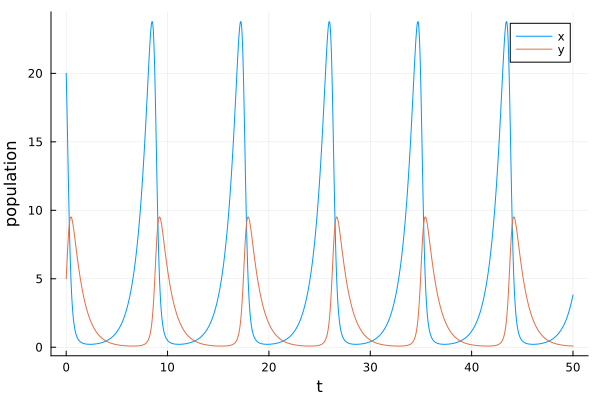

In [8]:
plot(sol, xlabel = "t", ylabel = "population", label = ["x" "y"])

LGTM